In [1]:
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 43.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [125]:
# Загрузка датасета
from rdkit import Chem
mols = Chem.SDMolSupplier("/content/drive/MyDrive/bogoslavskaya prac2/Копия herg.sdf") # На выходе array-like объект с молекулами в виде Mol объектов из rdkit

# Проверим общий размер
print(len(mols))

# Попробуем прочитать желаемое свойство и убедимся, что оно задано для всех молекул
# Используем конструкцию try/except, чтобы выбросить молекулы, для которых могут возникнуть ошибки
activities = []
clean_mols = []
for mol in mols:
    try:
        activities.append(mol.GetProp("herg_activity"))
        clean_mols.append(mol)
    except Exception:
        continue
print(len(activities))
print(len(clean_mols))

# дополнительная задача - оценим отношение активных и неактивных молекул в наборе

8154
8153
8153


In [126]:
def get_descr_value(molecule, descr_func):
    out_arr = np.zeros((1,), dtype=int)
    descriptor = descr_func(molecule)
    if isinstance(descriptor, rdkit.DataStructs.cDataStructs.ExplicitBitVect):
        DataStructs.ConvertToNumpyArray(descriptor, out_arr)
        return out_arr
    return descriptor

In [127]:
# Попробуем сформировать массивы 'X' и 'y':
# X - матрица, где каждой строчке будет соответствовать вектор из выбранных вами дескрипторов
# y - столбец со значениями активностей
# N.B. Убедитесь, что в тех случаях, когда не могут быть рассчитаны дескрипторы, вы не забыли исключить из дальнейшего рассмотрения соотвествующую активность
# E.g. можно использовать следующий или похожий код:

X = []
y = []

for i in range(len(clean_mols)):
    try:
        X.append(get_descr_value(clean_mols[i], AllChem.GetMACCSKeysFingerprint)) # обратим внимание, что можно конкатенировать вектора дескрипторов
        y.append(activities[i])
    except Exception:
        continue

In [128]:
# Разобьем набор на тренировочную и тестовую часть
from sklearn.model_selection import train_test_split
# Дополнительная задача - используем метод разбиения, учитывающий несбалансированность набора данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [89]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{'0': 0.680651221039449, '1': 1.8838821490467939}

In [129]:
# Дополнительная задача - попробуем использовать scaler (например, приведенный ниже)
# scaler тренируется на наборе X_train, а потом применяется к наборам X_train и X_test
# результаты его использования запишем в те же переменные
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

In [91]:

# Натренируем модель на готовом тренировочном наборе данных, например:

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

params = {'var_smoothing': np.logspace(0,100, num=1000)}
gnb_GS = GridSearchCV(estimator=gnb,
                 param_grid=params,
                 cv=5,   # use any cross validation technique
                 verbose=1,
                 scoring='accuracy')
gnb_GS.fit(X_train, y_train)

gnb_GS.best_params_

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


{'var_smoothing': 31.732296347349777}

In [92]:
from sklearn.model_selection import RandomizedSearchCV

gnb_RS = RandomizedSearchCV(estimator=gnb,
                            param_distributions = params,
                            cv = 2,
                            n_iter = 10,
                            n_jobs=-1)
gnb_RS.fit(X_train, y_train)

gnb_RS.best_params_

{'var_smoothing': 9.571521538992012e+80}

In [93]:
from sklearn.metrics import accuracy_score
y_pred_GS = gnb_GS.predict(X_test)
print(accuracy_score(y_test, y_pred_GS))

y_pred_RS = gnb_RS.predict(X_test)
print(accuracy_score(y_test, y_pred_RS))

0.7572041692213366
0.7345187001839363


In [94]:
# Дополнительная задача - нарисуем на этом этапе тепловую карту для confusion_matrix и график receiver operating characteristic

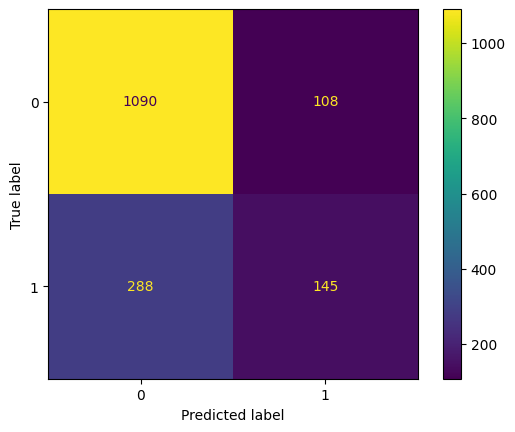

In [95]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_GS, labels=gnb_GS.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=gnb_GS.classes_)
disp.plot()
plt.show()

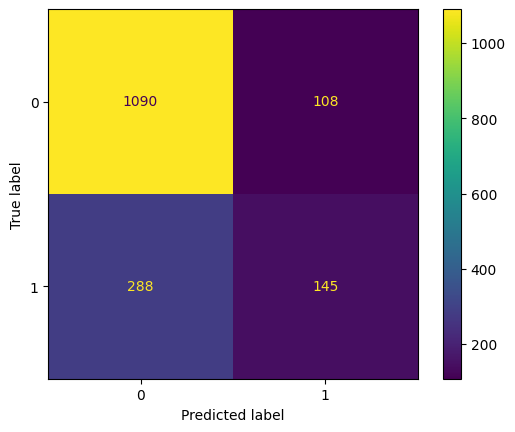

In [96]:

rs = confusion_matrix(y_test, y_pred_RS, labels=gnb_RS.classes_)
disp_rs = ConfusionMatrixDisplay(confusion_matrix=rs,
                              display_labels=gnb_RS.classes_)
disp.plot()
plt.show()

In [97]:
# Повторим процесс, варьируя дескрипторы, методы обучения и гиперпараметры методов для максмимизации качества модели
# Сколько дескрипторов и параметров методов достаточно рассмотреть?

In [130]:
import sklearn
from sklearn.neighbors import KNeighborsClassifier
import warnings
from sklearn.model_selection import cross_val_score

neigh = KNeighborsClassifier()
score = cross_val_score(neigh, X, y, cv=5)

In [131]:
import tqdm
from tqdm.auto import tqdm as tqdm

k_candidates = [i for i in range(1, 50)]
scores = []

for k in tqdm(k_candidates):
  neigh = KNeighborsClassifier(n_neighbors=k)
  score = cross_val_score(neigh, X_train, y_train, cv=5)
  scores.append(np.mean(score))

  0%|          | 0/49 [00:00<?, ?it/s]

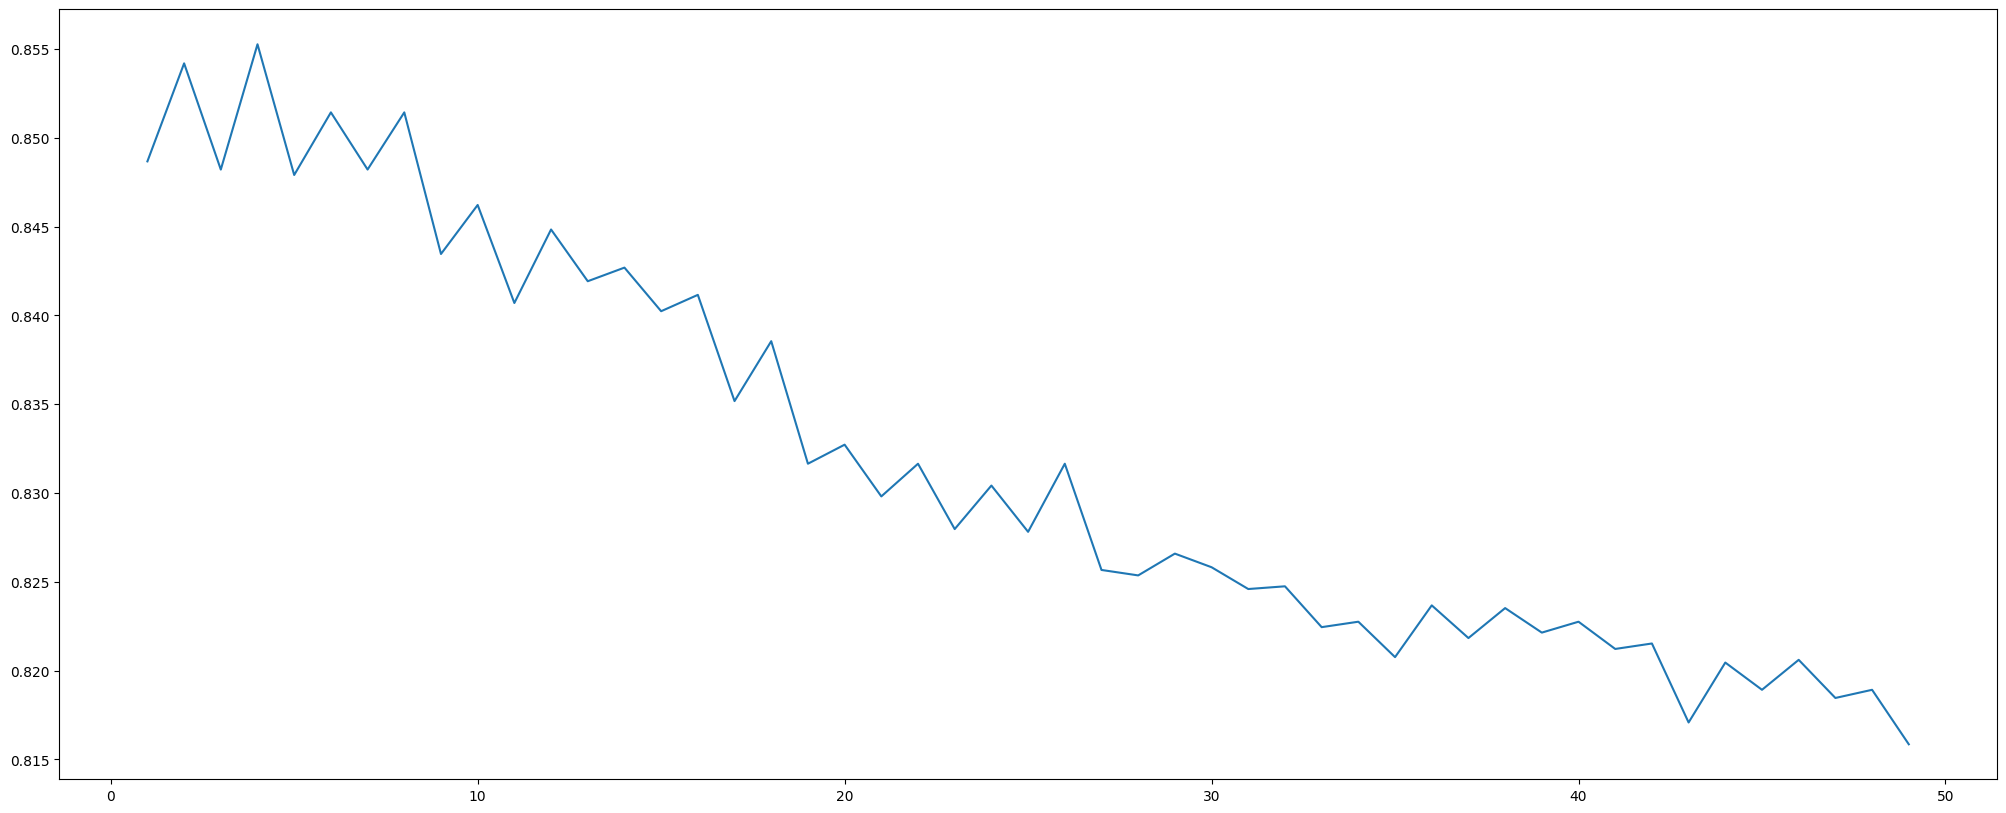

In [132]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 10))
plt.plot(np.arange(1, 50), scores)

In [133]:
k_best = np.argmax(scores) + 1
k_best

4

In [134]:
neigh_f = KNeighborsClassifier(n_neighbors=4, metric='cosine')
neigh_f.fit(X_train, y_train)
y_pred_neigh = neigh_f.predict(X_test)

In [135]:
# Рассчитаем максимальное количество метрик на готовом тестовом наборе данных, например:
print(accuracy_score(y_test, y_pred_neigh))

0.8749233599019006
